## Missing Fingers

In [1]:
import pandas as pd
import numpy as np
import pyro 

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

Importing the functions:

In [36]:
def normalize_sample(sample: torch.Tensor, k: int = 1000) -> torch.Tensor:
    ''' 
    `sample` is supposed to be a sample of values, returns probabilites across k bins.
    '''

    hist = torch.histc(sample, bins=k)
    return hist / hist.sum()



def weight(posterior: torch.Tensor, base=2.) -> float:
    '''
    Calculates the weight of the posterior distribution.
    The weight is defined as 1 - H(posterior) / H(uniform)
    where H is the entropy of the distribution.
        param: posterior: torch.Tensor - tensor of probabilities (not samples). 
    '''
    
    if not isinstance(base, torch.Tensor):  # Check if base is not a tensor
        base = torch.tensor(base) 

    initial_length = posterior.shape[-1]
    posterior = posterior[~torch.isnan(posterior)]
    removed_length = initial_length - posterior.shape[-1]

    if initial_length != posterior.shape[-1]:#raise warning
        warnings.warn(f"Removed {removed_length} nan values from posterior")

    if posterior.numel() == 0:
        return float('nan')

    grid_length = posterior.shape[-1]
    x = torch.linspace(0, 1, grid_length)

    uniform = dist.Beta(1, 1).log_prob(x).exp()
    uniform = uniform/uniform.sum()

    #uniform = normalize_sample(uniform, k = uniform.shape[-1])

    assert torch.allclose(uniform.sum(), torch.tensor(1.)), f"Sum of uniform distribution is {uniform.sum()}"
    assert torch.allclose(posterior.sum(), torch.tensor(1.)), f"Sum of posterior distribution is {posterior.sum()}"

    entropy_uniform = -torch.sum(uniform * torch.log(uniform) /torch.log(base))

    entropy_posterior = -torch.sum(posterior * torch.log(posterior) / torch.log(base))

    return 1 - entropy_posterior.item() / entropy_uniform.item()

def expected_weight(probs_of_evidence: torch.Tensor, outcome_prior: torch.Tensor,
                    posteriors: List[torch.Tensor],  base=2) -> torch.Tensor:    
    """
    Calculate the expected weight change given a prior distribution, 
    posterior distributions, and the probabilities of evidence.

    Args:
    probs_of_evidence (torch.Tensor): A tensor of probabilities representing the likelihood of the evidence.
    outcome_prior (torch.Tensor): A tensor representing the prior distribution of outcomes.
    posteriors (List[torch.Tensor]): A list of tensors representing the posterior distributions.
    base (int): The base for calculating the weight (default is 2).

    """
    
    weight_prior = weight(outcome_prior, base=base) 

    posterior_weights = torch.tensor([weight(posterior, base=base) for posterior in posteriors])

    print(posterior_weights)
    weight_changes = posterior_weights - weight_prior

    weighted_weight_changes = weight_changes * probs_of_evidence 
    
    assert probs_of_evidence.shape == weighted_weight_changes.shape, 'shape mismatch'

    expected_weight = weighted_weight_changes.sum()

    return {"expected_weight": expected_weight, "weight_prior": weight_prior, 
            "posterior_weights": posterior_weights, 
            "weight_changes": weight_changes, 
            "weighted_weight_changes": weighted_weight_changes}    
    
    
    
def plot_from_nodes(
    nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None, bins=20
):
    """
    The plot_from_nodes function takes a dictionary of nodes, processes their values, optionally filters the data,
     and plots histograms for specified nodes. The function then returns the processed DataFrame.
     Parameters:
     - nodes: Dictionary of nodes containing data.
     - filters: Optional dictionary to filter the data based on specified conditions.
     - nodes_to_plot: Optional list of specific nodes to plot. If not provided, plots all nodes.
     - bins: Number of bins for the histograms (default is 20).

     Returns:
     - DataFrame of the processed values.
    """

    values = {
        key: nodes[key]["value"].float().detach().cpu().numpy()
        for key in nodes.keys()
        if nodes[key]["name"] != "samples"
    }

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=bins, alpha=0.7, color="blue", density=True)
        plt.title(f"{key}, mean: {valuesDF[key].mean()}")
        plt.xlabel("value")
        plt.ylabel("frequency")
        sns.despine()
        plt.show()

    return valuesDF



Building Core model:

In [9]:
pyro.set_rng_seed(42)

def swedish_fingers_guilt_model(
        pr_identity: float = 0.01,               # Prior probability that the suspect is guilty
        rmp_fingers_sweden = 2 / 20000,          # RMP for Sweden
        pr_isis_if_not_guilty = 300 /10.6e6,                               
        pr_fingers_match_if_isis = 2 / 5000,     # RMP for ISIS memebers
        num_particles = 3e5                     
    ):
    
    with pyro.plate("particles", size=num_particles):
   
        guilty = pyro.sample("guilty", dist.Bernoulli(pr_identity))

        isis = pyro.sample("isis", dist.Bernoulli(
                                        guilty * 1 + (1 - guilty) * pr_isis_if_not_guilty
                                        )
                            )


        fingers_match_rmp = pyro.sample("fingers_match_not_isis", 
                                             # if guilty then 1
                                             # if not guilty then sample with probability rmp
                                                dist.Bernoulli(guilty * 1 + (1 - guilty) * (rmp_fingers_sweden)
                                                               )
                                            )
        

        fingers_match_isis = pyro.sample("fingers_match_isis", 
                                         # if guilty then 1
                                         # if not guilty then sample with probability pr_fingers_match_if_isis
                                            dist.Bernoulli(guilty * 1 + (1 - guilty) * ((pr_fingers_match_if_isis) * isis +
                                                              (1 - isis) * (rmp_fingers_sweden)
                                                                    )
                                                                )
                                                            ) 
        


    # Mask 1: fingers match
    evidence_mask_fingers_rmp = (fingers_match_rmp).bool()
    guilty_masked_fingers_rmp = pyro.deterministic(
        "guilty_masked_fingers_rmp",
        torch.where(evidence_mask_fingers_rmp, guilty, torch.tensor(float("nan")))            
        )

    
    posterior_guilty_fingers_rmp = pyro.deterministic(
        "posterior_guilty_fingers_rmp", torch.nanmean(guilty_masked_fingers_rmp, axis=0))
    

    # Mask 2: fingers match, isis
    evidence_mask_fingers_isis = (fingers_match_isis * isis).bool()
    guilty_masked_fingers_isis = pyro.deterministic(
        "guilty_masked_fingers_isis",
        torch.where(evidence_mask_fingers_isis, guilty, torch.tensor(float("nan")))            
        )
    
    posterior_guilty_fingers_isis = pyro.deterministic(
        "posterior_guilty_fingers_isis", torch.nanmean(guilty_masked_fingers_isis, axis=0))

        
        
    

    return {"guilty": guilty, "isis": isis, 'fingers_match_rmp': fingers_match_rmp, 
            'fingers_match_isis': fingers_match_isis,
            "posterior_guilty_fingers_rmp": posterior_guilty_fingers_rmp, 
            "posterior_guilty_fingers_isis": posterior_guilty_fingers_isis}
     

#set pyro random seed
pyro.set_rng_seed(422323)
swedish_fingers_guilt_model()

{'guilty': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'isis': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'fingers_match_rmp': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'fingers_match_isis': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'posterior_guilty_fingers_rmp': tensor(0.9871),
 'posterior_guilty_fingers_isis': tensor(1.)}

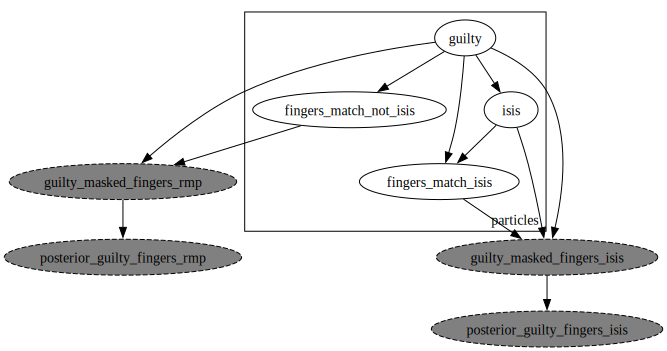

In [21]:
pyro.render_model(swedish_fingers_guilt_model, render_deterministic = True)


In [88]:
# extracting the posterior probabilities

with pyro.poutine.trace() as tr:
   pyro.set_rng_seed(4242)
   swedish_fingers_guilt_model(num_particles=1e6)

for key in tr.trace.nodes.keys():
        if key.startswith("posterior"):
                print(key, tr.trace.nodes[key]['value'])
                


posterior_guilty_fingers_rmp tensor(0.9909)
posterior_guilty_fingers_isis tensor(1.)


In [89]:

posterior_guilty_fingers_rmp = torch.tensor([
    1 - tr.trace.nodes['posterior_guilty_fingers_rmp']['value'], 
    tr.trace.nodes['posterior_guilty_fingers_rmp']['value'],      
])

posterior_guilty_fingers_isis = torch.tensor([
    1 - tr.trace.nodes['posterior_guilty_fingers_isis']['value'],  
    tr.trace.nodes['posterior_guilty_fingers_isis']['value'],     
])

print('posterior_guilty_fingers_rmp', posterior_guilty_fingers_rmp)
print('posterior_guilty_fingers_isis', posterior_guilty_fingers_isis)


pr_identity = 0.01              
rmp_fingers_sweden = 2 / 20000         
pr_isis_if_not_guilty = 300 /10.6e6                             
pr_fingers_match_if_isis = 2 / 5000


prior_guilt = torch.tensor([1 - pr_identity, pr_identity])  
print('prior_guilt', prior_guilt)

probs_of_evidence = torch.tensor([
    pr_isis_if_not_guilty,  
    pr_fingers_match_if_isis         
])
print('probs_of_evidence', probs_of_evidence)


posterior_guilty_fingers_rmp tensor([0.0091, 0.9909])
posterior_guilty_fingers_isis tensor([0., 1.])
prior_guilt tensor([0.9900, 0.0100])
probs_of_evidence tensor([2.8302e-05, 4.0000e-04])


In [90]:
expected_weights = expected_weight(
    probs_of_evidence, prior_guilt, 
    [posterior_guilty_fingers_rmp, posterior_guilty_fingers_isis]
)

print("Expected Weights:", expected_weights)

tensor([0.9253,    nan])
Expected Weights: {'expected_weight': tensor(nan), 'weight_prior': 0.9192068800330162, 'posterior_weights': tensor([0.9253,    nan]), 'weight_changes': tensor([0.0061,    nan]), 'weighted_weight_changes': tensor([1.7337e-07,        nan])}


A version with disitrbutions incorporated:

In [38]:

def HO_fingers_guilt_model(
 
    pr_identity: float = 0.01,    
    
    rmp_swedish_alpha: float = 2, rmp_swedish_beta: float = 20000, # not sure if it should be a point value or a dist.  
    pr_isis_if_not_guilty_alpha: float = 2, pr_isis_if_not_guilty_beta: float = 10.6e6, 
    pr_fingers_if_isis_alpha: float =  2, pr_fingers_if_isis_beta: float = 5000, 
    
    num_particles = 3e5
):
    with pyro.plate("particles", size=num_particles):
        
        guilty = pyro.sample("guilty", dist.Bernoulli(pr_identity))

        pr_isis_if_not_guilty = pyro.sample("pr_isis_if_not_guilty", dist.Beta(pr_isis_if_not_guilty_alpha, pr_isis_if_not_guilty_beta))
        
        isis = pyro.sample("isis", dist.Bernoulli(guilty * 1 + (1 - guilty) * pr_isis_if_not_guilty))

        rmp_swedish = pyro.sample("rmp_swedish", dist.Beta(rmp_swedish_alpha, rmp_swedish_beta))
     
        pr_fingers_if_isis = pyro.sample("pr_fingers_if_isis", dist.Beta(pr_fingers_if_isis_alpha, pr_fingers_if_isis_beta))
        
      
        fingers_match_rmp = pyro.sample("fingers_match_rmp", 
            dist.Bernoulli(guilty * 1 + (1 - guilty) * rmp_swedish))
        
        fingers_match_isis = pyro.sample("fingers_match_isis", 
            dist.Bernoulli(guilty * 1 + (1 - guilty) * (pr_fingers_if_isis * isis + (1 - isis) * rmp_swedish)))

        # Mask 1
        evidence_mask_fingers_rmp = fingers_match_rmp.bool()
        guilty_masked_fingers_rmp = pyro.deterministic(
            "guilty_masked_fingers_rmp",
            torch.where(evidence_mask_fingers_rmp, guilty, torch.tensor(float("nan")))
        )
        posterior_guilty_fingers_rmp = pyro.deterministic(
            "posterior_guilty_fingers_rmp", torch.nanmean(guilty_masked_fingers_rmp, axis=0))
        

        # Mask 2
        evidence_mask_fingers_isis = (fingers_match_isis * isis).bool()
        guilty_masked_fingers_isis = pyro.deterministic(
            "guilty_masked_fingers_isis",
            torch.where(evidence_mask_fingers_isis, guilty, torch.tensor(float("nan")))
        )
        posterior_guilty_fingers_isis = pyro.deterministic(
            "posterior_guilty_fingers_isis", torch.nanmean(guilty_masked_fingers_isis, axis=0))

    return {
        "pr_identity": pr_identity, 
        "pr_isis_if_not_guilty": pr_isis_if_not_guilty,
        "guilty": guilty, 
        "isis": isis, 
        "fingers_match_rmp": fingers_match_rmp,
        "fingers_match_isis": fingers_match_isis,
        "posterior_guilty_fingers_rmp": posterior_guilty_fingers_rmp,
        "posterior_guilty_fingers_isis": posterior_guilty_fingers_isis   
    }

pyro.set_rng_seed(422323)
HO_fingers_guilt_model()

{'pr_identity': 0.01,
 'pr_isis_if_not_guilty': tensor([2.1772e-07, 3.5676e-07, 1.2619e-07,  ..., 5.1180e-08, 2.2805e-07,
         1.5234e-07]),
 'guilty': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'isis': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'fingers_match_rmp': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'fingers_match_isis': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'posterior_guilty_fingers_rmp': tensor(0.9910),
 'posterior_guilty_fingers_isis': tensor(1.)}

In [31]:
with pyro.poutine.trace() as tr:
   pyro.set_rng_seed(42)
   HO_fingers_guilt_model(num_particles=1e6)

for key in tr.trace.nodes.keys():
        if key.startswith("posterior"):
                print(key, tr.trace.nodes[key]['value'])
                
nodes_fingers = tr.trace.nodes

posterior_guilty_fingers_rmp tensor(0.9898)
posterior_guilty_fingers_isis tensor(1.)


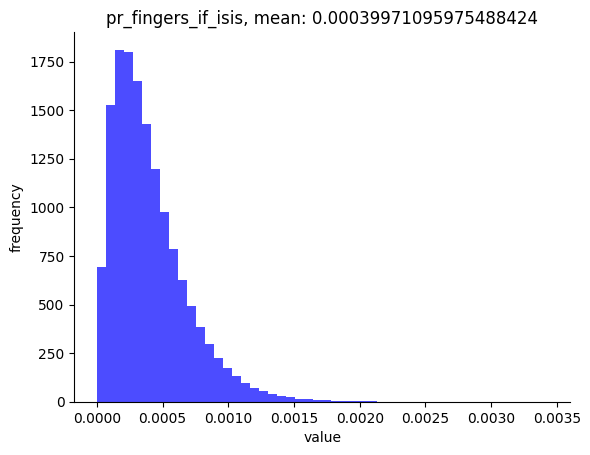

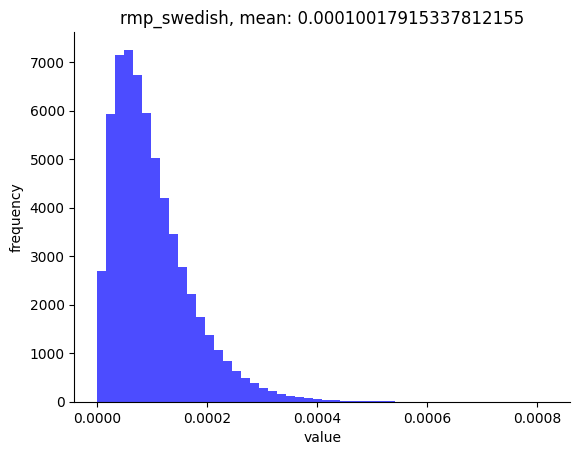

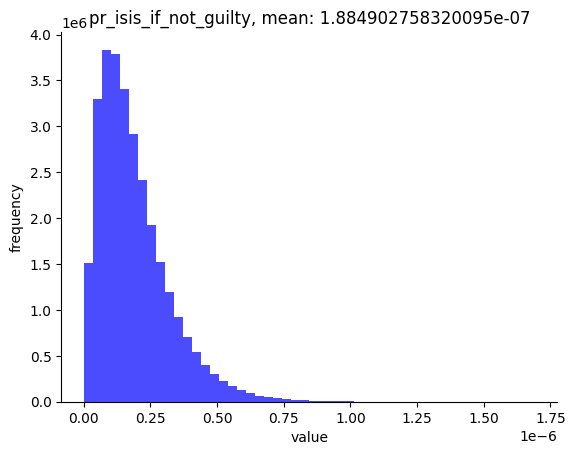

In [40]:
table = plot_from_nodes(
    nodes_fingers, nodes_to_plot=["pr_fingers_if_isis", "rmp_swedish", 'pr_isis_if_not_guilty'], bins=50
)


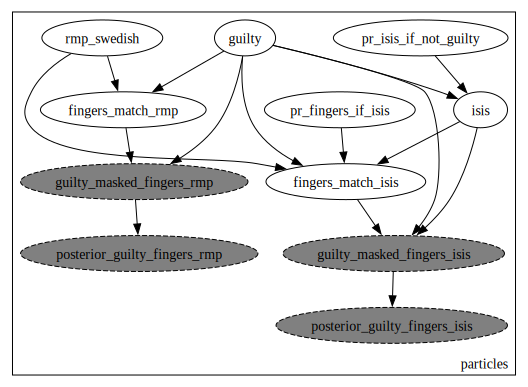

In [23]:
pyro.render_model(HO_fingers_guilt_model, render_deterministic = True)
# works only for a small number of particles

In [92]:
posterior_guilty_fingers_rmp = torch.tensor([
    1 - nodes_fingers['posterior_guilty_fingers_rmp']['value'], 
    nodes_fingers['posterior_guilty_fingers_rmp']['value'],      
])

posterior_guilty_fingers_isis = torch.tensor([
    1 - nodes_fingers['posterior_guilty_fingers_isis']['value'],  
    nodes_fingers['posterior_guilty_fingers_isis']['value'],     
])

print('posterior_guilty_fingers_rmp:', posterior_guilty_fingers_rmp)
print('posterior_guilty_fingers_isis:', posterior_guilty_fingers_isis)

pr_identity = 0.01              
prior_guilt = torch.tensor([1 - pr_identity, pr_identity])  
print('prior_guilt:', prior_guilt)

pr_isis_if_not_guilty = 300 / 10.6e6
pr_fingers_match_if_isis = 2 / 5000

probs_of_evidence = torch.tensor([
    pr_isis_if_not_guilty,  
    pr_fingers_match_if_isis         
])
print('probs_of_evidence:', probs_of_evidence)

posterior_guilty_fingers_rmp: tensor([0.0102, 0.9898])
posterior_guilty_fingers_isis: tensor([0., 1.])
prior_guilt: tensor([0.9900, 0.0100])
probs_of_evidence: tensor([2.8302e-05, 4.0000e-04])


In [93]:
posteriors = [posterior_guilty_fingers_rmp, posterior_guilty_fingers_isis]

result = expected_weight(
    probs_of_evidence, 
    prior_guilt, 
    posteriors
)

print("Expected Weights:", result)

tensor([0.9179,    nan])
Expected Weights: {'expected_weight': tensor(nan), 'weight_prior': 0.9192068800330162, 'posterior_weights': tensor([0.9179,    nan]), 'weight_changes': tensor([-0.0013,     nan]), 'weighted_weight_changes': tensor([-3.5587e-08,         nan])}
